# SYSEN 5880 Final Project

## Predicting NFL Offensive Play Results Using Machine Learning


Team Members:
 - Barrett Downs

## Imports

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn import naive_bayes
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read in Data

If the complete file is there, it will be read in. If not, then the smaller sample will be utilized.

If you need to generate the larger file, follow the instructions in the README.

In [30]:
full_file = '/Users/barrettdowns/NFL_draft/data/dataset_complete.csv'

sample_file = '../data/data_sample.csv'

if os.path.exists(full_file):
    data = pd.read_csv(full_file, low_memory=False)
    max_iterations = 10000
else:
    data = pd.read_csv(sample_file, low_memory=False)
    max_iterations = 1000

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305591 entries, 0 to 305590
Columns: 175 entries, score_home to defensive_extra_point_conv
dtypes: float64(148), int64(17), object(10)
memory usage: 408.0+ MB


## Utility Functions

In [31]:
# save results to csv
def add_to_csv(results, model):
    file = open('../data/model_results.csv', 'a')
    column_names = ['model',
                    'play_type',
                    'precision',
                    'recall',
                    'f1-score',
                    'support',
                    'overall_accuracy']
    labels = ('pass','run','punt','field_goal', 'macro avg', 'weighted avg')
    rows = list()
    for label in labels:
        row = (model, label, results[label]['precision'], results[label]['recall'], results[label]['f1-score'],
                results[label]['support'], results['accuracy'])
        rows.append(row)
  
    df_csv = pd.DataFrame(rows, columns=column_names)
    df_csv.to_csv(file, mode='a', index=False, header=not file.tell())

In [32]:
# add results to dataframe
def add_to_dataframe(results, model):
    column_names = ['model',
                    'target',
                    'measure',
                    'value']
    labels = ('pass','run','punt','field_goal', 'macro avg', 'weighted avg')
    rows = list()
    for label in labels:
        row = (model, label, 'precision', results[label]['precision'])
        rows.append(row)
        row = (model, label, 'recall', results[label]['recall'])
        rows.append(row)
        row = (model, label, 'f1-score', results[label]['f1-score'])
        rows.append(row)
        row = (model, 'accuracy', 'accuracy', results['accuracy'])
        rows.append(row)
        row = (model, label, 'support', results[label]['support'])
        rows.append(row)
  
    return pd.DataFrame(rows, columns=column_names)


In [33]:
# Define function to scale feature data on a positive range (0 to 1)
def scaleData(X):
    scaler = MinMaxScaler()

    for col in X.columns:
        X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))

In [34]:
# Define function to perform KFold cross validation and return scores
def perform_cross_validation(model, X, y, K, data):
    kf = model_selection.KFold(n_splits=K, shuffle=False)
    
    # For each fold, split feature and target sets into train and test sets and fit to model
    for train_index, test_index in kf.split(data):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    labels = ('pass','run','punt','field_goal')
    results = classification_report(y_test, y_pred, target_names=labels, output_dict=True)
    
    plot_confusion_matrix(model, X_test, y_test, display_labels=['pass','run','punt','field_goal'], cmap=plt.cm.Blues, normalize='all')
    plt.show()
    return results

## Data Cleanup

In [35]:
# Need to drop columns with non numerical datatypes
data = data.drop(columns=[
                    'temp_range', 
                    'wind_bins', 
                    'sky',
                    'precipitation',
                    'posteam',
                    'posteam_type',
                    'defteam',
                    'time',
                    'return_team',
                    'replay_or_challenge_result',
                    'score_home',
                    'score_away',
                    'avg_temp',
                    'avg_dewpoint',
                    'avg_humidity',
                    'quarter_end',
                    'drive',
                    'score_differential',
                    'score_differential_post'])

# fil in missing data
data.epa.fillna(0, inplace=True)
data.wpa.fillna(0, inplace=True)
data.home_wp_post.fillna(0, inplace=True)
data.away_wp_post.fillna(0, inplace=True)
data.gameId.fillna(0, inplace=True)
data.officialId.fillna(0, inplace=True)
data.ep.fillna(0, inplace=True)
data.wp.fillna(0, inplace=True)
data.def_wp.fillna(0, inplace=True)
data.home_wp.fillna(0, inplace=True)
data.away_wp.fillna(0, inplace=True)
data.return_yards.fillna(0, inplace=True)

# Drop rows that have any missing values in Down column
data = data.dropna(subset=['down'])

y = data['play_type']
X = data.drop(columns=['play_type'])
X = X.reset_index()

scaleData(X)

In [ ]:
print(X.isnull().sum())  # Check for missing values in X
print(np.isnan(X).any())  # Check for invalid values in X
print(np.isinf(X).any())  # Check for invalid values in X
print(y.isnull().sum())  # Check for missing values in y
print(np.isnan(y).any())  # Check for invalid values in y
print(np.isinf(y).any())  # Check for invalid values in y

In [ ]:
# Check for missing values in X
missing_X = X.isnull().sum()
print("Missing values in X:")
print(missing_X[missing_X > 0])

# Check for invalid values in X
invalid_X = np.isnan(X) | np.isinf(X)
print("Invalid values in X:")
print(X.columns[invalid_X.any()])

# Check for missing values in y
missing_y = y.isnull().sum()
print("Missing values in y:")
print(missing_y[missing_y > 0])

# Check for invalid values in y
invalid_y = np.isnan(y) | np.isinf(y)
print("Invalid values in y:")
print(invalid_y.any())


In [ ]:
print(np.isnan(X).any())  # Check for invalid values in X
print(np.isinf(X).any())  # Check for invalid values in X

In [ ]:
# Filter columns with missing or invalid values
missing_cols = X.columns[X.isnull().sum() > 0]
invalid_cols = X.columns[np.isnan(X).any() | np.isinf(X).any()]
problematic_cols = np.unique(np.concatenate([missing_cols, invalid_cols]))
X_filtered = X.drop(columns=problematic_cols)

# Print the filtered dataframe
print(X_filtered.head())

## Models

The following models will be used to predict the play type
- Naive Bayes - Multinomial
- Naive Bayes - Gaussian
- Multinomial Logistic Regression
- Linear SVC
- Decision Tree
- K Nearest Neighbors Classifier

### Naive Bayes Multinomial Model

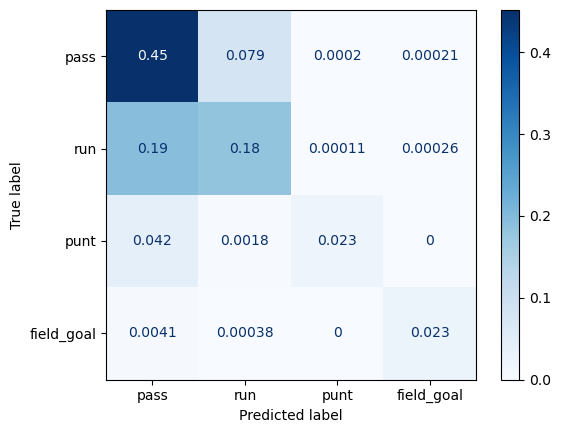

In [41]:
nbc_res = perform_cross_validation(naive_bayes.MultinomialNB(), X_filtered, y, 5, data)

add_to_csv(nbc_res, 'NBM')

df = add_to_dataframe(nbc_res, 'NBM')

### Naive Bayes Guassian

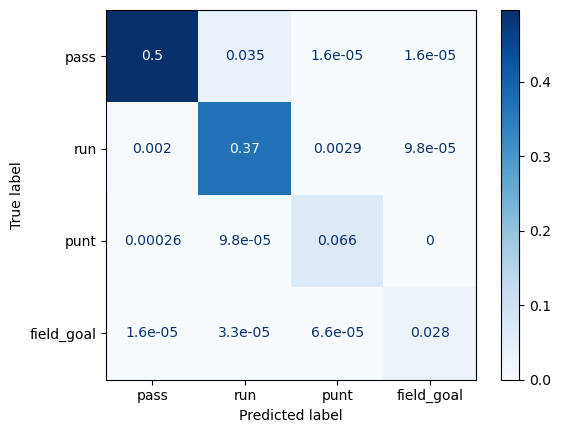

In [42]:
nbc_res = perform_cross_validation(naive_bayes.GaussianNB(), X_filtered, y, 5, data)

add_to_csv(nbc_res, 'GNB')

res = add_to_dataframe(nbc_res, 'GNB')
df = df.append(res)

### Logistic Regression (multinomial)

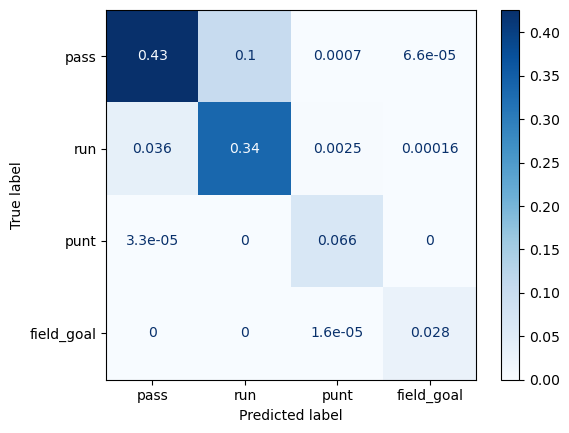

In [43]:
lr_res = perform_cross_validation(LogisticRegression(class_weight='balanced', random_state=0, max_iter=max_iterations), X_filtered, y, 5, data)

add_to_csv(lr_res, 'LRM')

res = (add_to_dataframe(lr_res, 'LRM'))
df = df.append(res)

### Linear SVC model

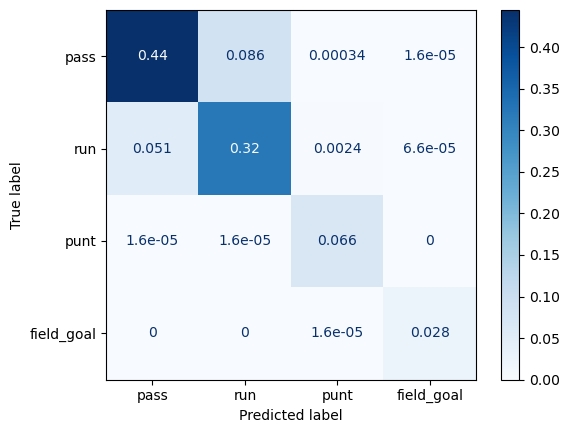

In [44]:
svc_res = perform_cross_validation(LinearSVC(random_state=0, tol=1e-5, max_iter=(max_iterations + 2000), class_weight="balanced"), X_filtered, y, 5, data)

add_to_csv(svc_res, 'SVC')

res = add_to_dataframe(svc_res, 'SVC')
df = df.append(res)

### Decision Tree

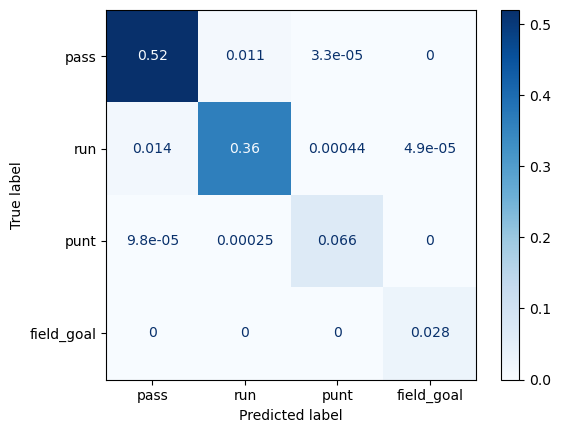

In [45]:
dt_res = perform_cross_validation(DecisionTreeClassifier(criterion='entropy'), X_filtered, y, 5, data)

add_to_csv(dt_res, 'DT')

res = add_to_dataframe(dt_res, 'DT')
df = df.append(res)

### KNN Classifier

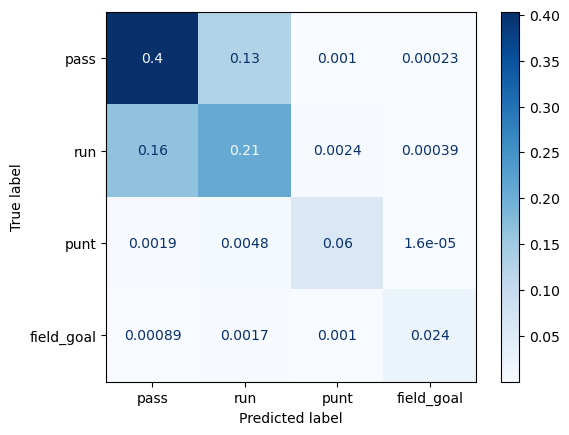

In [46]:
knn_res = perform_cross_validation(KNeighborsClassifier(n_jobs=-1, n_neighbors=5), X_filtered, y, 5, data)

add_to_csv(knn_res, 'KNN')

res = add_to_dataframe(knn_res, 'KNN')
df = df.append(res)

# df.info()
df.to_csv('df.csv')

## Visualize Results

### Compare Model Accuracy

<AxesSubplot:xlabel='model', ylabel='value'>

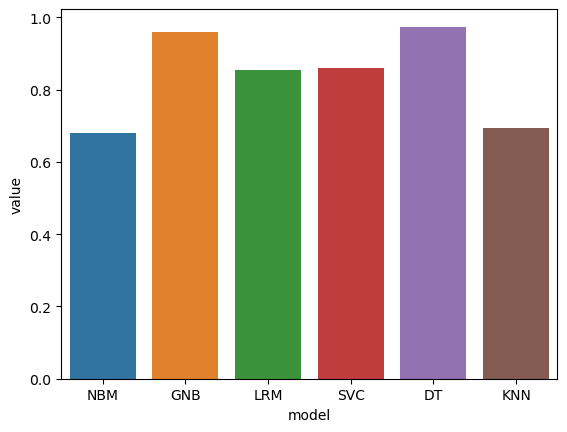

In [47]:
# get the overall accuracy
accuracy = df.loc[((df['target'] == 'accuracy') & (df['measure'] == 'accuracy'))].drop_duplicates(subset=None, keep="first")
sns.barplot(data=accuracy, x='model', y='value')

### Predicting Pass Plays

<AxesSubplot:xlabel='model', ylabel='value'>

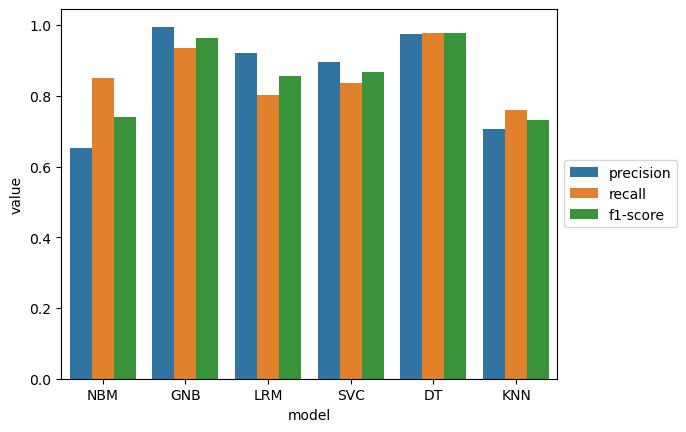

In [48]:
# compare the pass plays
pass_plays = df.loc[((df['target'] == 'pass') & (df['measure'] != 'support') & (df['measure'] != 'accuracy'))]

bar = sns.barplot(x='model', y='value', hue='measure', data=pass_plays)
bar.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
bar

### Predicting Run Plays

<AxesSubplot:xlabel='model', ylabel='value'>

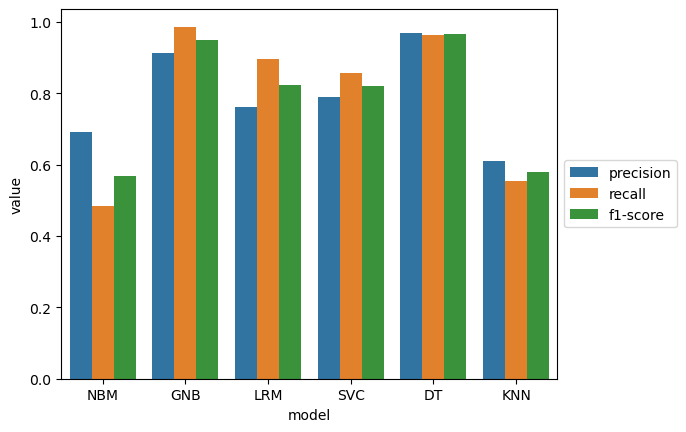

In [49]:
# compare the run plays
run_plays = df.loc[((df['target'] == 'run') & (df['measure'] != 'support') & (df['measure'] != 'accuracy'))]

bar = sns.barplot(x='model', y='value', hue='measure', data=run_plays)
bar.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
bar

### Predicting Field Goal Plays

<AxesSubplot:xlabel='model', ylabel='value'>

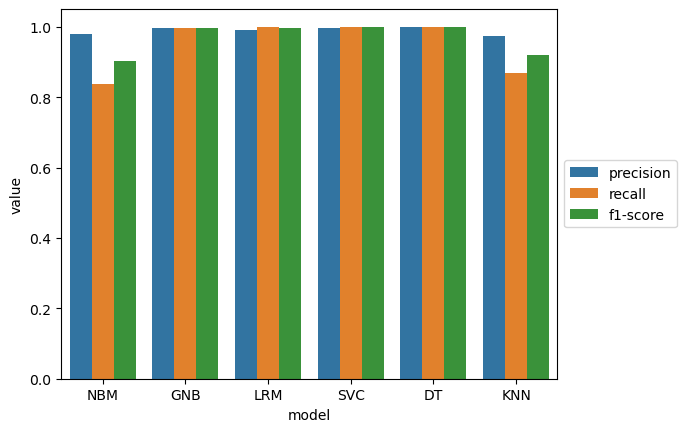

In [50]:
# compare field goals
fg_plays = df.loc[((df['target'] == 'field_goal') & (df['measure'] != 'support') & (df['measure'] != 'accuracy'))]

bar = sns.barplot(x='model', y='value', hue='measure', data=fg_plays)
bar.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
bar

### Predicting Punt Plays

<AxesSubplot:xlabel='model', ylabel='value'>

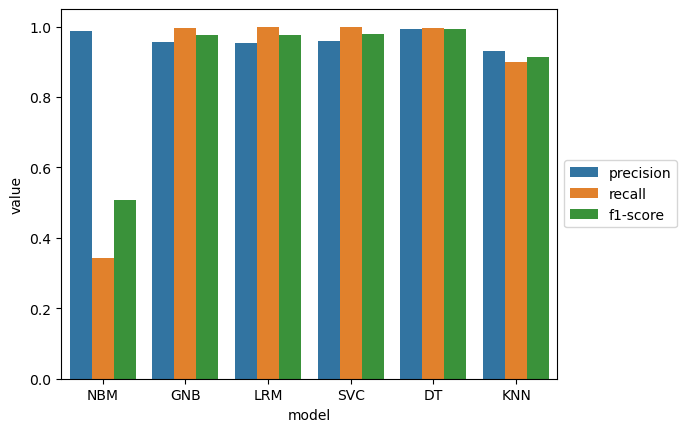

In [51]:
# compare punts
punt_plays = df.loc[((df['target'] == 'punt') & (df['measure'] != 'support') & (df['measure'] != 'accuracy'))]

bar = sns.barplot(x='model', y='value', hue='measure', data=punt_plays)
bar.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
bar

### Macro Average

<AxesSubplot:xlabel='model', ylabel='value'>

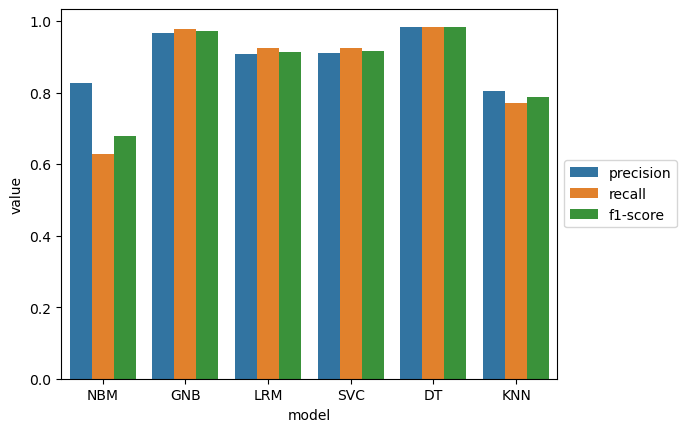

In [52]:
# macro average (overall)
ma_plays = df.loc[((df['target'] == 'macro avg') & (df['measure'] != 'support') & (df['measure'] != 'accuracy'))]

bar = sns.barplot(x='model', y='value', hue='measure', data=ma_plays)
bar.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
bar

### Weighted Average

<AxesSubplot:xlabel='model', ylabel='value'>

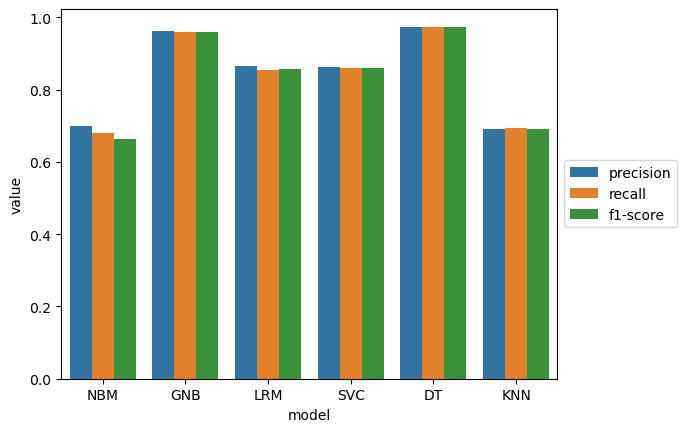

In [53]:
# weighted average (overall)
wa_plays = df.loc[((df['target'] == 'weighted avg') & (df['measure'] != 'support') & (df['measure'] != 'accuracy'))]

bar = sns.barplot(x='model', y='value', hue='measure', data=wa_plays)
bar.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
bar